In [1]:
import numpy as np
import pandas as pd

from scipy import polyval, stats
import math
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.formula.api as sf
import statsmodels.api as sm

from scipy.stats import normaltest  #для проверки распределения на нормальность
from scipy.stats import shapiro  #для проверки распределения на нормальность
from statsmodels.graphics.gofplots import qqplot  #для проверки распределения на нормальность

from scipy.stats import spearmanr  #корреляция Спирмена

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

from collections import Counter

from datetime import timedelta

from math import log
from math import exp
from scipy.stats import boxcox

In [2]:
# настройки отображения графиков
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

In [3]:
df_original = pd.read_csv('resource/Barcelona airbnb 10.2020.csv')

In [4]:
# создание копии для внесения изменений
df = df_original.copy(deep=True)

In [5]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,21974,Comf. double room/private bathroom,73163,Andres,Ciutat Vella,el Barri Gòtic,41.37973,2.17631,Private room,55,3,2,2017-11-06,0.05,3,139
1,23197,Forum DeLuxe 5 mins Walk To CCIB Center & Sea★,90417,Etain (Marnie),Sant Martí,el Besòs i el Maresme,41.41291,2.22063,Entire home/apt,180,3,52,2019-12-15,0.45,2,358
2,32711,Sagrada Familia area - Còrsega 1,135703,Nick,Gràcia,el Camp d'en Grassot i Gràcia Nova,41.40566,2.17015,Entire home/apt,109,2,63,2020-02-22,0.56,5,0
3,34241,Private Double room - Plaza Real,73163,Andres,Ciutat Vella,el Barri Gòtic,41.37916,2.17535,Private room,40,30,8,2013-07-15,0.06,3,0
4,34981,VIDRE HOME PLAZA REAL on LAS RAMBLAS,73163,Andres,Ciutat Vella,el Barri Gòtic,41.37978,2.17623,Entire home/apt,131,4,149,2020-03-11,1.22,3,92


                                  Shape and data types of the data 
                                     (генеральная совокупность)

In [6]:
df.shape

(19896, 16)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19896 entries, 0 to 19895
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              19896 non-null  int64  
 1   name                            19884 non-null  object 
 2   host_id                         19896 non-null  int64  
 3   host_name                       19889 non-null  object 
 4   neighbourhood_group             19896 non-null  object 
 5   neighbourhood                   19896 non-null  object 
 6   latitude                        19896 non-null  float64
 7   longitude                       19896 non-null  float64
 8   room_type                       19896 non-null  object 
 9   price                           19896 non-null  int64  
 10  minimum_nights                  19896 non-null  int64  
 11  number_of_reviews               19896 non-null  int64  
 12  last_review                     

In [8]:
# Список долей отсутствующих записей для каждого признака
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing * 100)))

id - 0%
name - 0%
host_id - 0%
host_name - 0%
neighbourhood_group - 0%
neighbourhood - 0%
latitude - 0%
longitude - 0%
room_type - 0%
price - 0%
minimum_nights - 0%
number_of_reviews - 0%
last_review - 30%
reviews_per_month - 30%
calculated_host_listings_count - 0%
availability_365 - 0%


                                    Data cleaning

### Отсутствующие данные

In [9]:
# Внесение недостающих значений в столбцы name и host_name
df['name'] = df['name'].fillna('MISSING')
df['host_name'] = df['host_name'].fillna('MISSING')

In [10]:
# проверка заполнения недостающих значений 'name'
missing_df = df['name'].str.contains('MISSING')
df[missing_df]['name']

1869    MISSING
2285    MISSING
2685    MISSING
2698    MISSING
2804    MISSING
2890    MISSING
3001    MISSING
3012    MISSING
3358    MISSING
4533    MISSING
4561    MISSING
4661    MISSING
Name: name, dtype: object

Text(0.5, 1.0, 'Тепловая карта пропущенных значений')

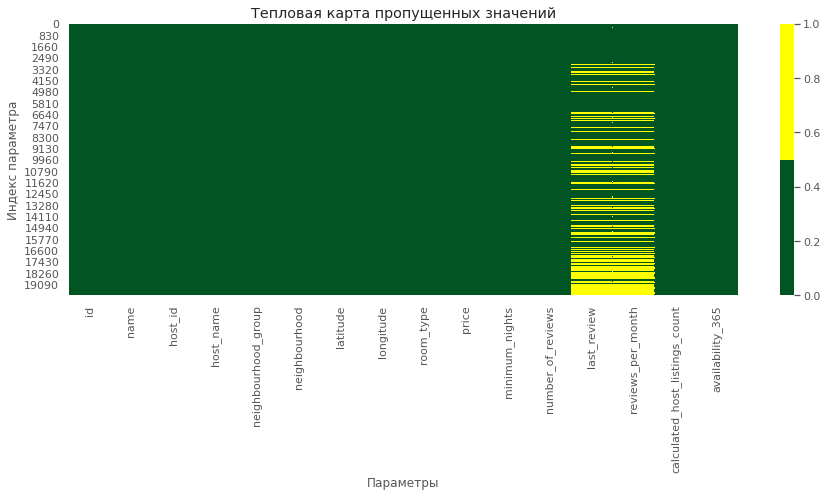

In [11]:
# Отсутствующие значения на тепловой карте
cols = df.columns
colours = ['#005522', '#ffff00']
# желтый - пропущенные данные
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))
plt.xlabel('Параметры')
plt.ylabel('Индекс параметра')
plt.title('Тепловая карта пропущенных значений')

In [12]:
# замененна значения NAN новым значением 0
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'host_id'}>,
        <AxesSubplot:title={'center':'latitude'}>],
       [<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'minimum_nights'}>],
       [<AxesSubplot:title={'center':'number_of_reviews'}>,
        <AxesSubplot:title={'center':'reviews_per_month'}>,
        <AxesSubplot:title={'center':'calculated_host_listings_count'}>],
       [<AxesSubplot:title={'center':'availability_365'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

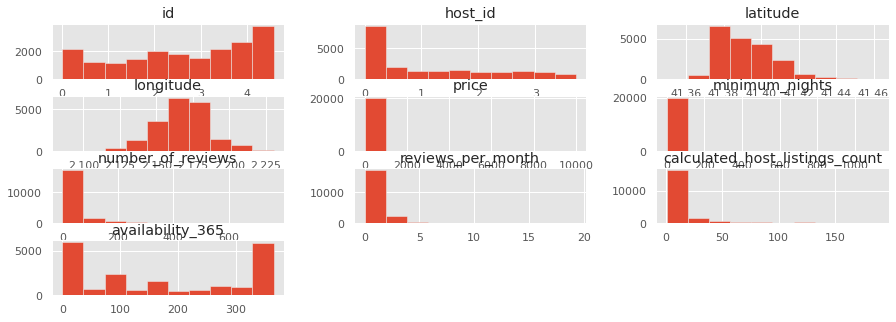

In [13]:
df.hist()

In [14]:
coef, p = spearmanr(df['reviews_per_month'], df['number_of_reviews'])
print('Коэффициент корреляции Спирмена: %.3f' % coef)

alpha = 0.05
if p > alpha:
    print('Статистически значимая корреляция не обнаружена p=%.3f' % p)
else:
    print('Обнаружена статистически значимая корреляция p=%.3f' % p)

Коэффициент корреляции Спирмена: 0.950
Обнаружена статистически значимая корреляция p=0.000


In [15]:
#фильтр по пустым ячейкам в столбце reviews_per_month
filtered_nullable = df[df['reviews_per_month'].isnull()]
len(filtered_nullable)

0

In [16]:
#выбор 2х столбцов по заданному фильтру
filtered_nullable = filtered_nullable[[
    'number_of_reviews', 'reviews_per_month'
]]
# количество отзывов при нулевом значении параметра в месяц
filtered_nullable['number_of_reviews'].value_counts()

Series([], Name: number_of_reviews, dtype: int64)

In [17]:
# Проверка долей отсутствующих записей для каждого признака после внесения недостающих значений
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing * 100)))

id - 0%
name - 0%
host_id - 0%
host_name - 0%
neighbourhood_group - 0%
neighbourhood - 0%
latitude - 0%
longitude - 0%
room_type - 0%
price - 0%
minimum_nights - 0%
number_of_reviews - 0%
last_review - 30%
reviews_per_month - 0%
calculated_host_listings_count - 0%
availability_365 - 0%


### Exploratory Data analysis

#### Анализ параметра id

In [18]:
# проверка на уникальность
[k for k, v in Counter(df['id']).items() if v > 1]
# все значения id уникальны, повторений нет, следовательно весь датасет содержит уникальные данные

[]

#### Анализ параметра price

In [19]:
# Описательная статистика
df['price'].describe()

count    19896.000000
mean        85.995074
std        207.216127
min          0.000000
25%         34.000000
50%         54.000000
75%         93.000000
max      10000.000000
Name: price, dtype: float64

In [20]:
df['price'].median()

54.0

In [21]:
df['price'].mode()[0]

50

In [22]:
# исключение нулевого значения из набора данных
df = df[df['price'] > 0]

In [23]:
# Проверка распределения на нормальность тестом К^2 Д'Агостино

data = df.price

stat, p = normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Нормальное распределение')
else:
    print('Распределение не является нормальным')

Statistics=52174.124, p=0.000
Распределение не является нормальным


Text(0.5, 1.0, 'Распределение параметра price')

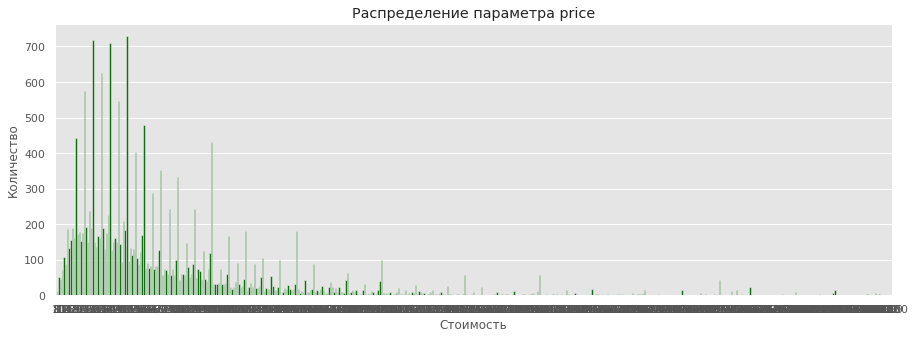

In [24]:
# Распределение параметра price
sns.countplot(x='price', data=df, color='green')
plt.xlabel('Стоимость')
plt.ylabel('Количество')
plt.title('Распределение параметра price')

##### Нетипичные значения

/home/kate/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

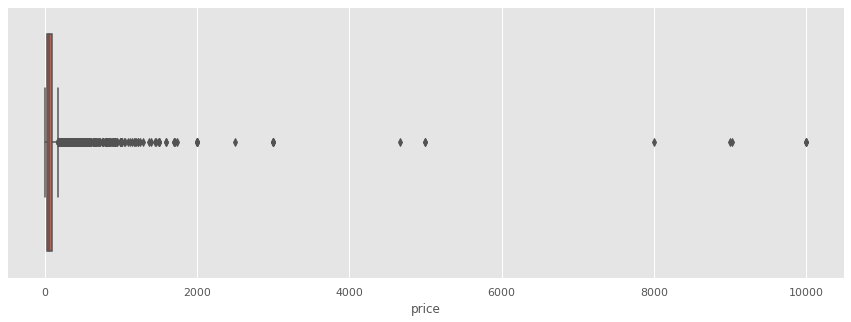

In [25]:
sns.boxplot(df['price'], orient='h')

In [26]:
# Объем нетипичных данных параметра price

df_price = df['price']
upper_quartile = np.percentile(df_price, 75)
lower_quartile = np.percentile(df_price, 25)
iqr = upper_quartile - lower_quartile  #Межквартильный диапазон
upper_whisker = df_price[df_price <= upper_quartile +
                              1.5 * iqr].max()  #1.5 межквартильных диапазона

filtered_emissions = df[
    df['price'] >
    upper_whisker]  #выборка данных с нетипичными значениями стоимости

len(filtered_emissions) / len(
    df
) * 100  #процент нетипичных значений стоимости в генеральной совокупности

7.031917567227946

##### Оценка нетипичных данных по длительности аренды

Text(0.5, 1.0, 'Длительность аренды для нетипичных значений')

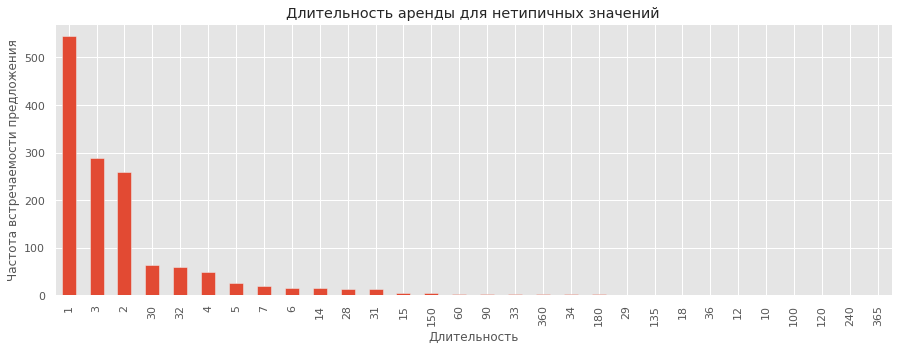

In [27]:
# Длительность аренды для нетипичных значений
filtered_emissions['minimum_nights'].value_counts().plot.bar()
plt.xlabel('Длительность')
plt.ylabel('Частота встречаемости предложения')
plt.title('Длительность аренды для нетипичных значений')

In [28]:
#процент длительной аренды (от месяца до года) в выборке нетипичной стоимости
len(filtered_emissions[filtered_emissions['minimum_nights'] > 29]) / len(
    filtered_emissions) * 100

11.508220157255183

##### Анализ описания предложений по параметру name для выявления маркеров премиальной категории

In [29]:
# Приведение регистров символов к общему виду
df['name'] = df['name'].str.lower()  #нижний регистр для всех строк
filtered_emissions['name'] = filtered_emissions['name'].str.lower(
)  #нижний регистр для всех строк
df['name'] = df['name'].str.strip(
)  #удаление символов в начале и конце строки
df['name'] = df['name'].str.replace('\\.', '')  #удаление точек
df['name'] = df['name'].str.replace('\\bstreet\\b',
                                              'st')  #введение сокращения

<ipython-input-29-aa255e1a020c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_emissions['name'] = filtered_emissions['name'].str.lower(


In [30]:
# Поиск наиболее часто встречающихся слов в столбце name генеральной совокупности
Counter(' '.join(df['name']).split()).most_common(10)

[('in', 4725),
 ('room', 4526),
 ('apartment', 3504),
 ('barcelona', 2608),
 ('with', 2213),
 ('the', 2109),
 ('habitación', 1871),
 ('en', 1791),
 ('-', 1671),
 ('de', 1640)]

In [31]:
# Поиск наиболее часто встречающихся слов в столбце name filtered_emissions
Counter(' '.join(filtered_emissions['name']).split()).most_common(10)

[('apartment', 352),
 ('in', 293),
 ('with', 197),
 ('barcelona', 176),
 ('the', 161),
 ('luxury', 108),
 ('de', 107),
 ('-', 101),
 ('room', 99),
 ('terrace', 96)]

In [32]:
# процент предложений с указанием атрибута Lux в генеральной совокупности
df_lux = df[df['name'].str.contains(r'lux*')]
len(df_lux) / len(df) * 100

7.454134204574013

In [33]:
# стандартное отклонение выборки с атрибутом lux
df_lux['price'].std()

378.4141330497012

In [34]:
# процент предложений с указанием атрибута Lux в выборке нетипичной стоимости
df_lux_emission = filtered_emissions[
    filtered_emissions['name'].str.contains(r'lux*')]
len(df_lux_emission) / len(filtered_emissions) * 100

18.799142244460327

In [35]:
# процент краткосрочной аренды с указанием атрибута Lux в выборке нетипичной стоимости
df_lux_emission_short = df_lux_emission[
    df_lux_emission['minimum_nights'] < 29]
len(df_lux_emission_short) / len(filtered_emissions) * 100

15.511079342387418

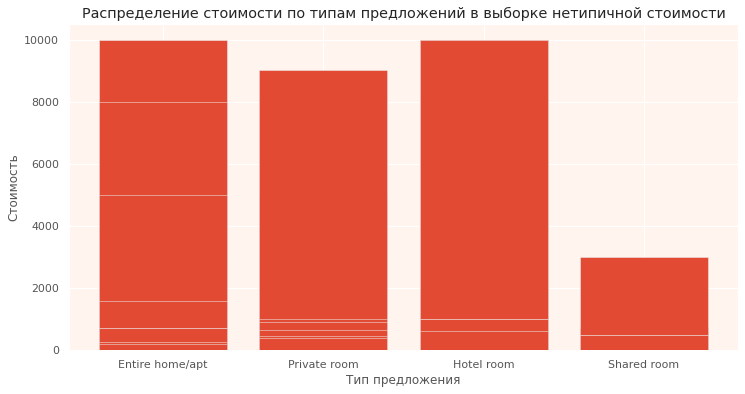

In [36]:
# Распределение стоимости по типам предложений в выборке нетипичной стоимости

x = filtered_emissions['room_type']
y1 = filtered_emissions['price']

fig, ax = plt.subplots()

ax.bar(x, y1)

ax.set_facecolor('seashell')
fig.set_figwidth(12)  #  ширина Figure
fig.set_figheight(6)  #  высота Figure
plt.xlabel('Тип предложения')
plt.ylabel('Стоимость')
plt.title('Распределение стоимости по типам предложений в выборке нетипичной стоимости')

plt.show()

In [37]:
# исключение выбросов по заданному фильтру - Shared room нетипичной стоимости со сроком аренды менее 30 дней без атрибута Luxury

filtered_df = df[(df['room_type'] == "Shared room")
                      & (df['price'] > upper_whisker)
                      & (df['minimum_nights'] <= 30)
                      & (~df['name'].str.contains('lux', regex=False))]

df = df.drop(filtered_df.index)

##### Категоризация параметра price

In [38]:
# Группировка стоимости price_class
price_class = {}

price_category = 1

count_rows_price = df['price'].count() + 1

first_quartile = np.percentile(df.price, 25)
second_quartile = np.percentile(df.price, 50)
third_quartile = np.percentile(df.price, 75)
fourth_quartile = upper_whisker
premium = df['price'].max()

for price in range(1, count_rows_price):

    if (price <= first_quartile):
        price_category = 1

    elif (price > first_quartile and price <= second_quartile):
        price_category = 2

    elif (price > second_quartile and price <= third_quartile):
        price_category = 3

    elif (price > third_quartile and price <= fourth_quartile):
        price_category = 4

    elif (price > fourth_quartile and price <= premium):
        price_category = 5

    price_class[price] = price_category

# price_class

In [39]:
# Добавление столбца с номинативными данными категорий стоимости
df['price_class'] = df['price'].map(price_class)

Text(0.5, 1.0, 'Представление категорий стоимости')

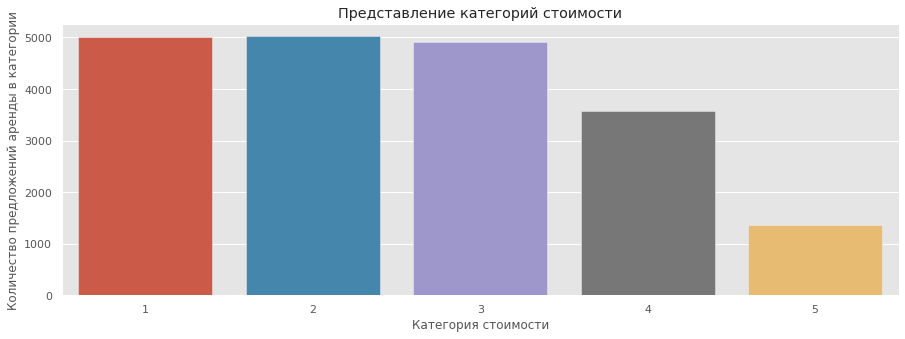

In [40]:
# Распределение параметра price_class
sns.countplot(x='price_class', data=df)
plt.xlabel('Категория стоимости')
plt.ylabel('Количество предложений аренды в категории')
plt.title('Представление категорий стоимости')

####                                    Анализ параметра host id

In [41]:
# проверка на уникальность
df['host_id'].nunique() / len(df)

0.4909649166960286

In [42]:
df['host_id'].nunique()

9754

In [43]:
# сравнение частоты встречаемости id каждого хозяина с параметром calculated_host_listings_count в исходных данных

tags, C = np.unique(df_original.host_id, return_counts=1, return_inverse=1)[1:]
df_original['host_id_сount'] = C[
    tags]  #создание столбца с числом встречаемости каждого уникального значения host_id

df_original['filtered_host'] = df_original['host_id_сount'] == df_original[
    'calculated_host_listings_count']  #булевое значение при сравнении столбцов
df_original['filtered_host'].value_counts()

True    19896
Name: filtered_host, dtype: int64

#### Анализ параметра host_name

In [44]:
# объем уникальных значений в столбце host_name
df['host_name'].nunique() / len(df)

0.2102984849247496

In [45]:
# словарь уникальных значений с учетом группировки по host_id
dict_name_host = df.groupby(df.host_name)['host_id'].nunique()

In [46]:
# список наиболее популярных имен с учетом уникальности по параметру host_id
[
    keys for keys, values in dict_name_host.items()
    if values == dict_name_host.max()
]

['Maria']

In [47]:
# Частота встречаемости самого популярного имени
dict_name_host.max() / df['host_id'].nunique()

0.010662292392864465

#### Анализ параметра calculated_host_listings_count

Text(0.5, 1.0, 'Количество предложений у арендодателей')

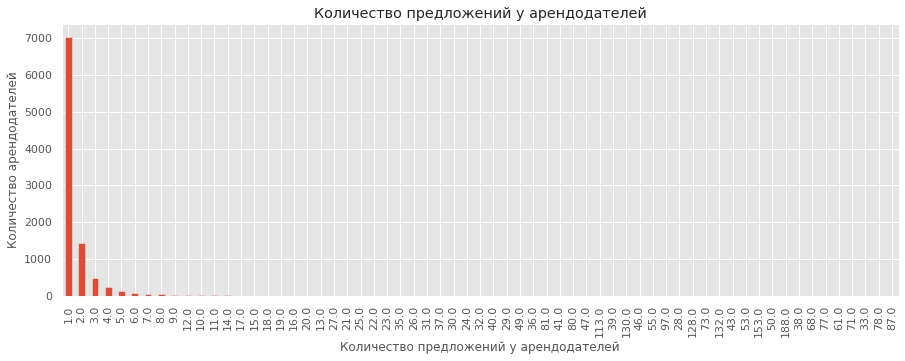

In [48]:
# Количество предложений размещения у арендодателей

groupby_count_house = df.groupby('host_id').mean()[[
    'calculated_host_listings_count'
]].calculated_host_listings_count.value_counts()

groupby_count_house.plot.bar()

plt.xlabel('Количество предложений у арендодателей')
plt.ylabel('Количество арендодателей')
plt.title('Количество предложений у арендодателей')

In [49]:
# объем арендодателей по количеству предлагаемых вариантов размещения
df.groupby('host_id').mean()[[
    'calculated_host_listings_count'
]].calculated_host_listings_count.value_counts(normalize=True)

1.0     0.720320
2.0     0.148349
3.0     0.050338
4.0     0.024093
5.0     0.014353
          ...   
61.0    0.000103
71.0    0.000103
33.0    0.000103
78.0    0.000103
87.0    0.000103
Name: calculated_host_listings_count, Length: 63, dtype: float64

#### Анализ параметра room_type

In [50]:
df['room_type'].value_counts(normalize=True)

Private room       0.497206
Entire home/apt    0.475059
Hotel room         0.018322
Shared room        0.009413
Name: room_type, dtype: float64

Text(0.5, 1.0, 'Количество предложений по типам размещения')

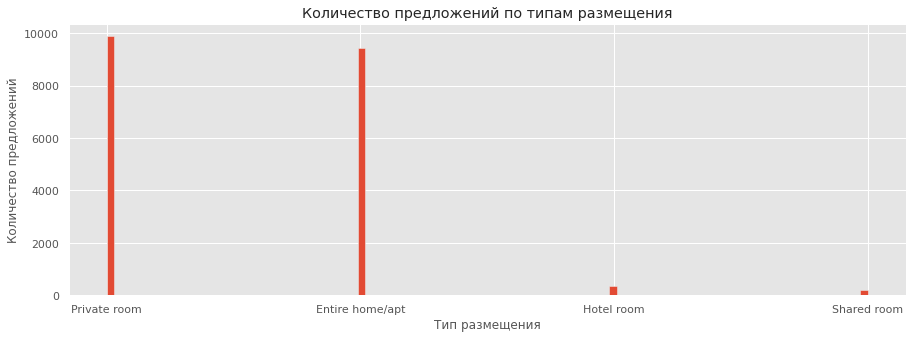

In [51]:
# Количество предложений по типам размещения
df['room_type'].hist(bins=100)
plt.xlabel('Тип размещения')
plt.ylabel('Количество предложений')
plt.title('Количество предложений по типам размещения')

In [52]:
# Группировка стоимости price_class
room_class = {}

for room in df['room_type']:
    if (room == 'Private room'):
        room_category = 1

    elif (room == 'Entire home/apt'):
        room_category = 2

    elif (room == 'Hotel room'):
        room_category = 3

    elif (room == 'Shared room'):
        room_category = 4

    room_class[room] = room_category

In [53]:
df['room_class'] = df['room_type'].map(room_class)

####                                  Анализ параметра minimum_nights

In [54]:
df['minimum_nights'].describe()

count    19867.000000
mean        11.384608
std         27.779097
min          1.000000
25%          1.000000
50%          3.000000
75%         29.000000
max       1124.000000
Name: minimum_nights, dtype: float64

Text(0.5, 1.0, 'Количество предложений с минимальной длительностью аренды')

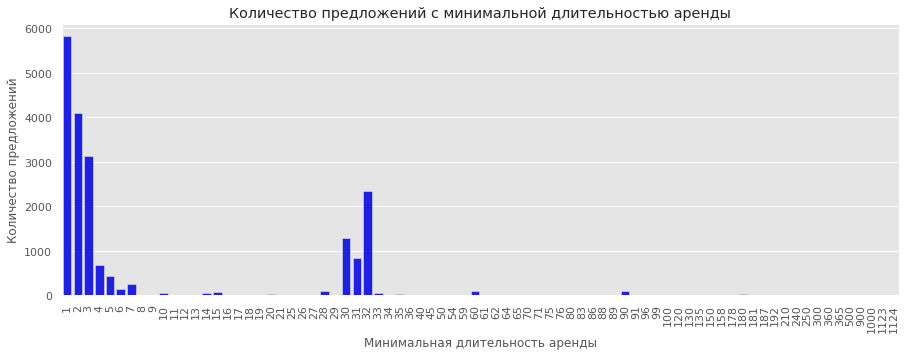

In [55]:
# Распределение minimum_nights
sns.countplot(x='minimum_nights', data=df, color='blue')
plt.xlabel('Минимальная длительность аренды')
plt.xticks(rotation=90)
plt.ylabel('Количество предложений')
plt.title('Количество предложений с минимальной длительностью аренды')

/home/kate/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='minimum_nights'>

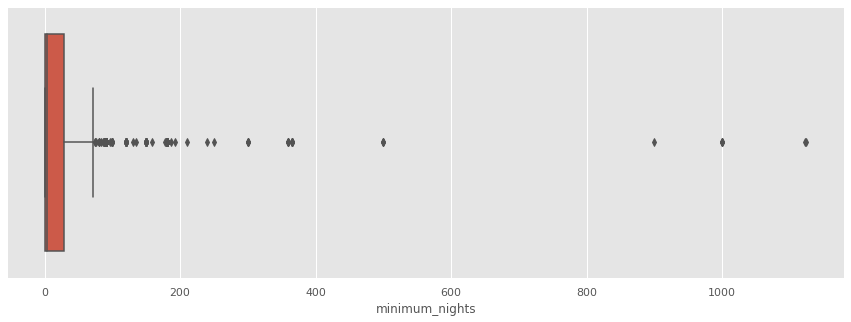

In [56]:
sns.boxplot(df['minimum_nights'], orient='h')

In [57]:
# Группировка по длительности аренды
minimum_nights_class = {}

minimum_nights_category = 1

max_count_nights = df['minimum_nights'].count()

for minimum_nights in range(1, max_count_nights):

    if (minimum_nights < 30):
        minimum_nights_category = 1

    elif (minimum_nights >= 30):
        minimum_nights_category = 30

    minimum_nights_class[minimum_nights] = minimum_nights_category

# minimum_nights_class

In [58]:
# Добавление столбца с номинативными данными категории длительности аренды
# 2 категории длительности аренды (краткосрочная <30 дней, долгосрочная >30 дней)
df['minimum_nights_class'] = df['minimum_nights'].map(
    minimum_nights_class)

####                                        Анализ параметра number_of_reviews

In [59]:
df['number_of_reviews'].describe()

count    19867.000000
mean        32.189561
std         63.037271
min          0.000000
25%          0.000000
50%          4.000000
75%         34.000000
max        761.000000
Name: number_of_reviews, dtype: float64

Text(0.5, 1.0, 'Распределение количества отзывов')

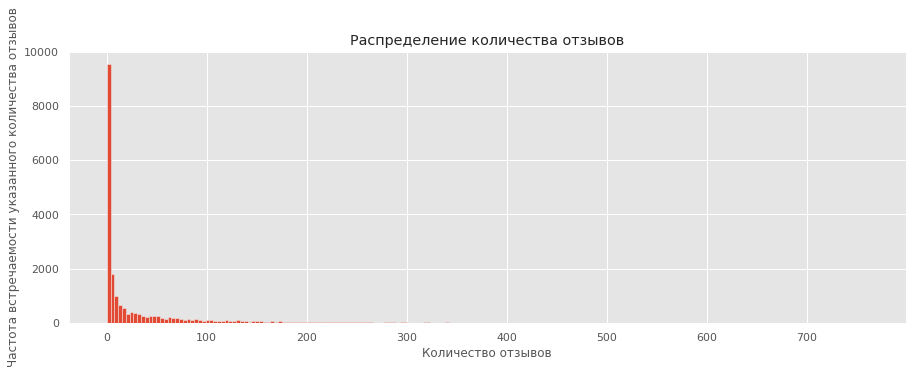

In [60]:
# Распределение параметра number_of_reviews
df['number_of_reviews'].hist(bins=200)
plt.xlabel('Количество отзывов')
plt.ylabel('Частота встречаемости указанного количества отзывов')
plt.title('Распределение количества отзывов')

In [61]:
# количество предложений без отзывов
df['number_of_reviews'].value_counts(normalize=True)

0      0.294810
1      0.097045
2      0.050234
3      0.038254
4      0.028691
         ...   
343    0.000050
470    0.000050
454    0.000050
438    0.000050
455    0.000050
Name: number_of_reviews, Length: 431, dtype: float64

#### Анализ параметра reviews_per_month

In [62]:
df['reviews_per_month'].describe()

count    19867.000000
mean         0.779576
std          1.156950
min          0.000000
25%          0.000000
50%          0.230000
75%          1.120000
max         19.290000
Name: reviews_per_month, dtype: float64

Text(0.5, 1.0, 'Распределение количества ежемесячных отзывов')

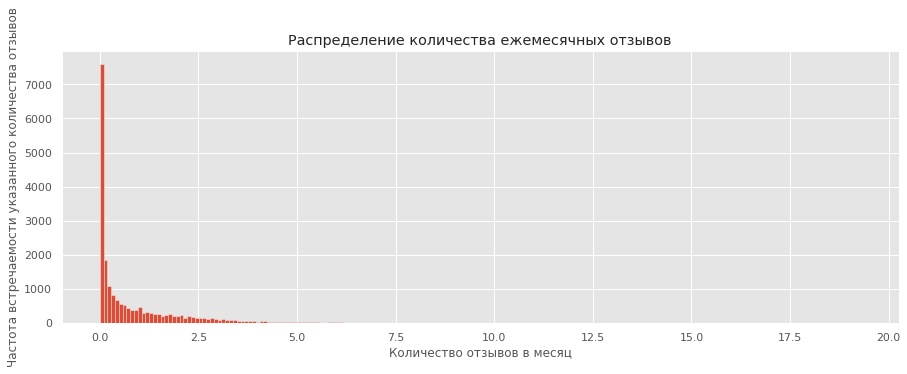

In [63]:
# Распределение параметра reviews_per_month
df['reviews_per_month'].hist(bins=200)
plt.xlabel('Количество отзывов в месяц')
plt.ylabel('Частота встречаемости указанного количества отзывов')
plt.title('Распределение количества ежемесячных отзывов')

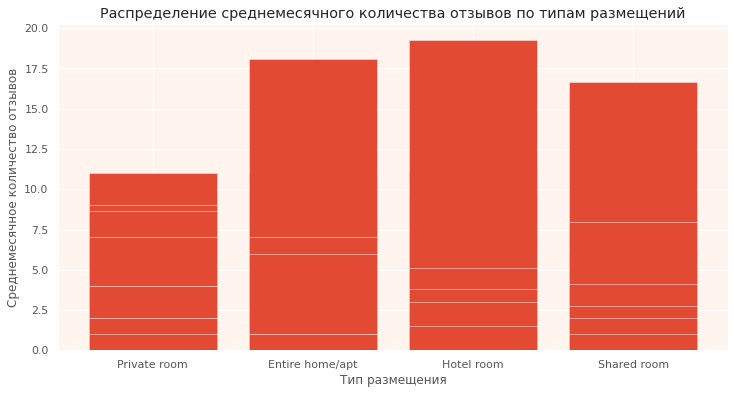

In [64]:
# распределение среднемесячного количества отзывов по типам размещений

x = df['room_type']
y1 = df['reviews_per_month']

fig, ax = plt.subplots()

ax.bar(x, y1)

ax.set_facecolor('seashell')
fig.set_figwidth(12)  #  ширина Figure
fig.set_figheight(6)  #  высота Figure
plt.xlabel('Тип размещения')
plt.ylabel('Среднемесячное количество отзывов')
plt.title(
    'Распределение среднемесячного количества отзывов по типам размещений')

plt.show()

#### Анализ параметра last_review 

In [65]:
# корректировка формата даты
df['last_review_dt'] = pd.to_datetime(df['last_review'])

Text(0.5, 1.0, 'Дата последнего отзыва у актуальных предложений размещения')

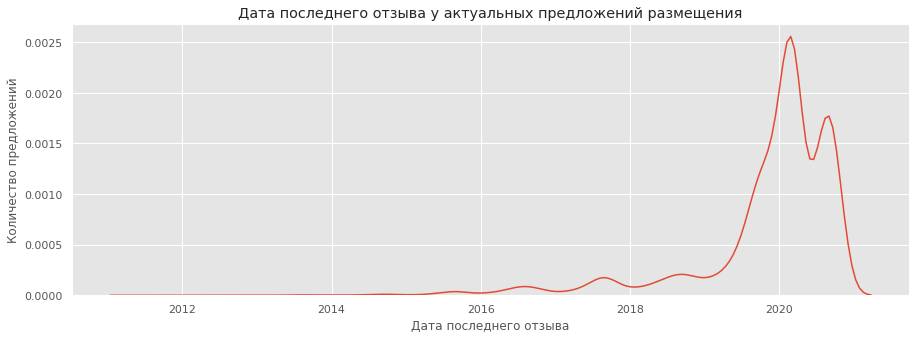

In [66]:
# Дата последнего отзыва у актуальных предложений размещения
sns.kdeplot(data=df, x='last_review_dt')
plt.xlabel('Дата последнего отзыва')
plt.ylabel('Количество предложений')
plt.title('Дата последнего отзыва у актуальных предложений размещения')

In [67]:
# дата последнего отзыва является наиболее близкой к дате выгрузки

# дата последнего отзыва:
recent_date = pd.to_datetime(df['last_review_dt']).max()

last_date = recent_date - timedelta(days=30)
last_date

Timestamp('2020-09-16 00:00:00')

In [68]:
# карта последних отзывов
last_review_dict = {}

for i in df['last_review_dt']:
    if (i >= last_date):
        last_review_category = 2

    elif (i < last_date) and i != 0:
        last_review_category = 1

    else:
        last_review_category = 0

    last_review_dict[i] = last_review_category

In [69]:
# Присвоение рангов для дат последних отзывов
df['last_review_rang'] = df['last_review_dt'].map(last_review_dict)

####                                Анализ параметра neighbourhood_group

In [70]:
df['neighbourhood_group'].value_counts(normalize=True)

Eixample               0.336387
Ciutat Vella           0.238738
Sants-Montjuïc         0.113706
Sant Martí             0.102079
Gràcia                 0.083958
Sarrià-Sant Gervasi    0.042231
Horta-Guinardó         0.031661
Les Corts              0.021141
Sant Andreu            0.016560
Nou Barris             0.013540
Name: neighbourhood_group, dtype: float64

Text(0.5, 1.0, 'Количество предложений для аренды по группам районов')

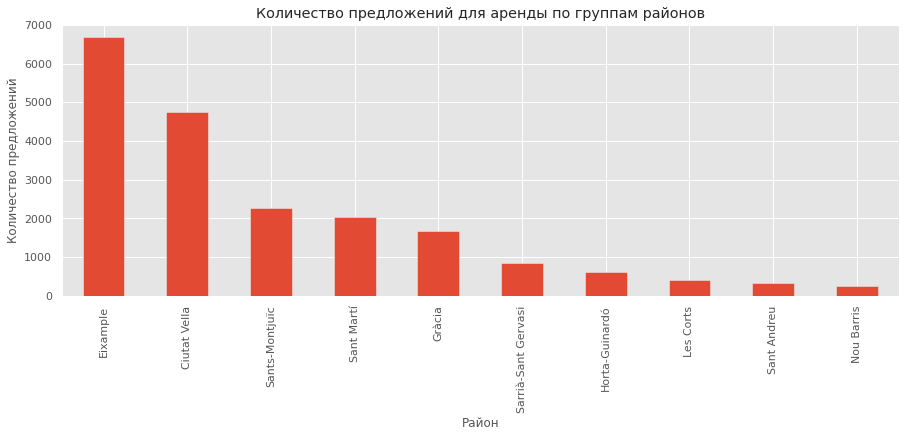

In [71]:
# Количество предложений для аренды по группам районов
df['neighbourhood_group'].value_counts().plot.bar()
plt.xlabel('Район')
plt.ylabel('Количество предложений')
plt.title('Количество предложений для аренды по группам районов')

In [72]:
# карта номеров групп районов
neighbourhood_set = set(df['neighbourhood_group'])

neighbourhood_dict = {}

for i, area_name in enumerate(neighbourhood_set):
    neighbourhood_dict[area_name] = i + 1

In [73]:
neighbourhood_dict

{'Eixample': 1,
 'Les Corts': 2,
 'Nou Barris': 3,
 'Sant Martí': 4,
 'Ciutat Vella': 5,
 'Gràcia': 6,
 'Horta-Guinardó': 7,
 'Sant Andreu': 8,
 'Sants-Montjuïc': 9,
 'Sarrià-Sant Gervasi': 10}

In [74]:
# Добавление номеров для групп районов
df['neighbourhood_group_index'] = df['neighbourhood_group'].map(
    neighbourhood_dict)

#### Анализ параметра neighbourhood 

In [75]:
df['neighbourhood'].value_counts(normalize=True)

la Dreta de l'Eixample                   0.107414
el Raval                                 0.079831
el Barri Gòtic                           0.070720
Sant Pere, Santa Caterina i la Ribera    0.063925
la Sagrada Família                       0.055167
                                           ...   
Ciutat Meridiana                         0.000352
Torre Baró                               0.000201
Can Peguera                              0.000151
Canyelles                                0.000101
Baró de Viver                            0.000050
Name: neighbourhood, Length: 71, dtype: float64

In [76]:
# карта номеров районов
neighbourhood_set = set(df['neighbourhood'])

neighbourhood_dict = {}

for i, area_name in enumerate(neighbourhood_set):
    neighbourhood_dict[area_name] = i + 1

In [77]:
# Добавление номера для районов
df['neighbourhood_index'] = df['neighbourhood'].map(
    neighbourhood_dict)

Text(0.5, 1.0, 'Количество предложений для аренды по районам')

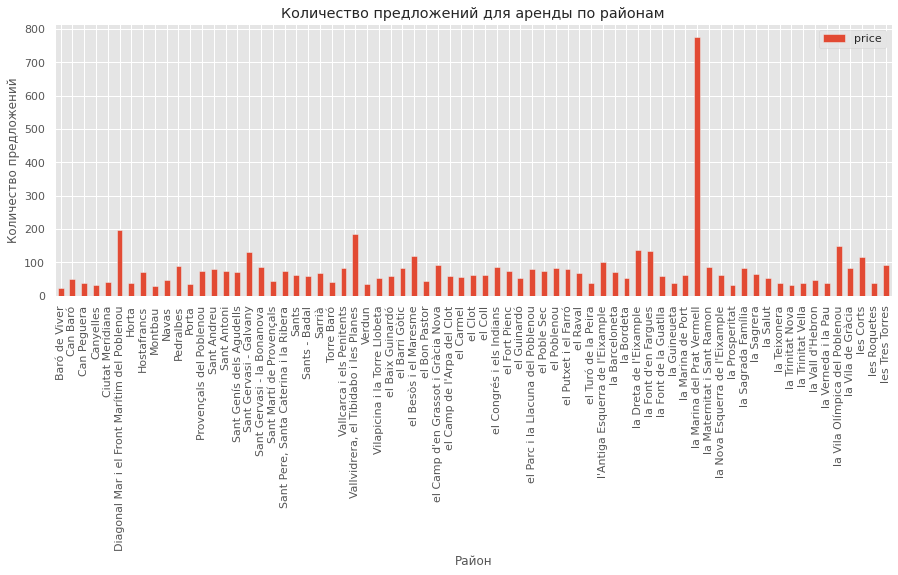

In [78]:
# Средняя стоимость аренды по районам
df.pivot_table(values=['price'], index=['neighbourhood']).plot(kind='bar')

plt.xlabel('Район')
plt.ylabel('Количество предложений')
plt.title('Количество предложений для аренды по районам')

In [79]:
# предложения в районе la Marina del Prat Vermell
df_max_mean_neighbourhood = df[df['neighbourhood'] ==
                                    'la Marina del Prat Vermell']
# объем предложений в районе 'la Marina del Prat Vermell' от общего числа предложений по городу
len(df_max_mean_neighbourhood) / len(df)

0.0006040167111290079

In [80]:
# Описание предложения с нетипичной стоимостью аренды
df_max_mean_neighbourhood[df_max_mean_neighbourhood['price'] ==
                          df_max_mean_neighbourhood['price'].max()]['name']

5573    luxury motor yacht in port vell
Name: name, dtype: object

#### Анализ параметров latitude и longitude

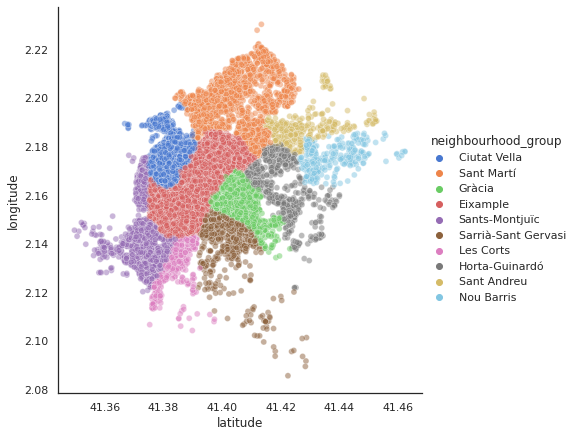

In [81]:
# Распределение геоданных по кластерам групп районов
sns.set_theme(style='white')

sns.relplot(x='latitude',
            y='longitude',
            hue='neighbourhood_group',
            sizes=(40, 400),
            alpha=.5,
            palette='muted',
            height=6,
            data=df)

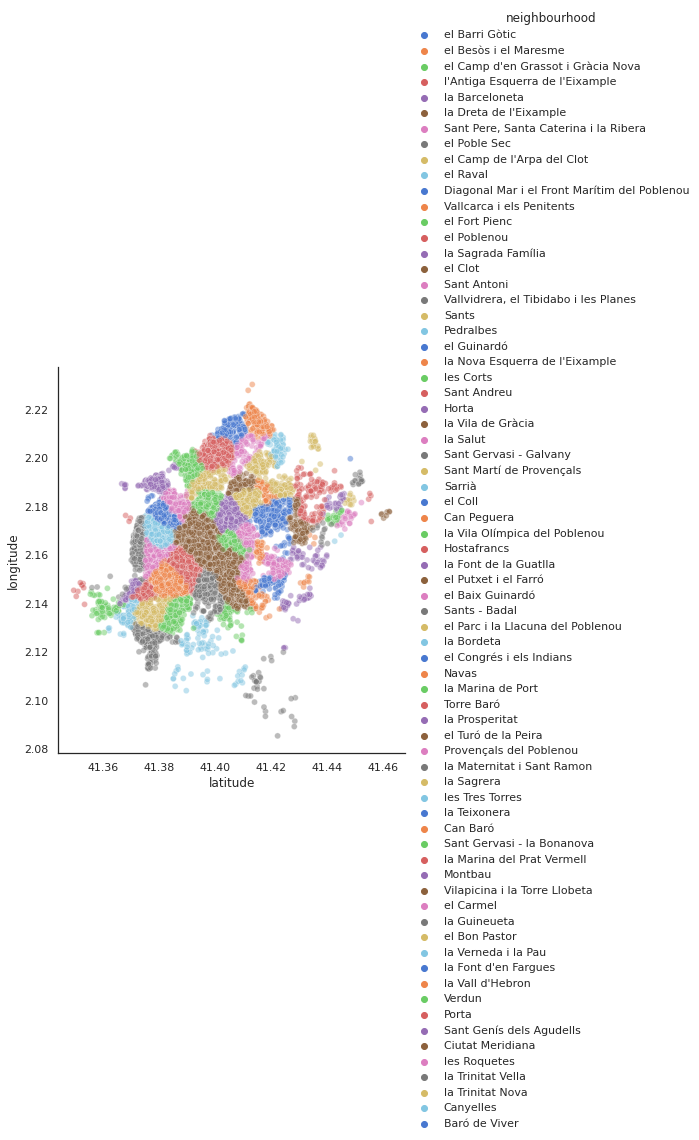

In [82]:
# Распределение геоданных по кластерам районов
sns.set_theme(style='white')

sns.relplot(x='latitude',
            y='longitude',
            hue='neighbourhood',
            sizes=(60, 50),
            alpha=.5,
            palette='muted',
            height=6,
            data=df)

####                                     Анализ параметра availability_365

In [83]:
df['availability_365'].describe()

count    19867.000000
mean       175.040419
std        147.267574
min          0.000000
25%          1.000000
50%        167.000000
75%        346.000000
max        365.000000
Name: availability_365, dtype: float64

In [84]:
df['availability_365'].value_counts(normalize=True)

0      0.229879
365    0.108824
364    0.049529
90     0.030302
1      0.024765
         ...   
215    0.000201
235    0.000201
52     0.000201
187    0.000201
238    0.000201
Name: availability_365, Length: 366, dtype: float64

Text(0.5, 1.0, 'Количество доступных дней для бронирования')

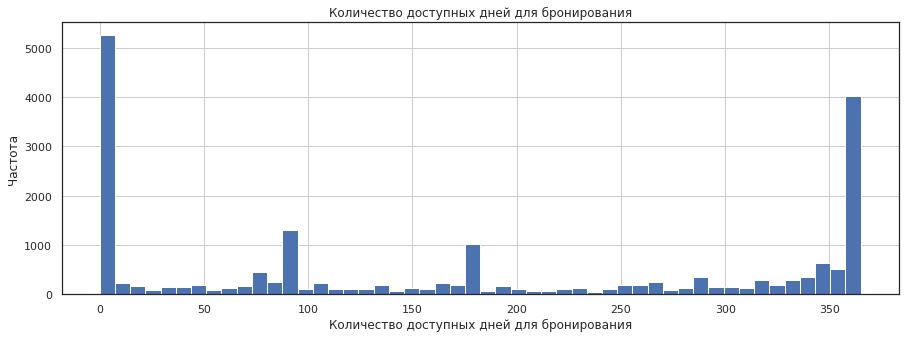

In [85]:
# распределение параметра availability_365
df['availability_365'].hist(bins=50)
plt.xlabel('Количество доступных дней для бронирования')
plt.ylabel('Частота')
plt.title('Количество доступных дней для бронирования')

Text(0.5, 1.0, 'Доступность предложений аренды по районам')

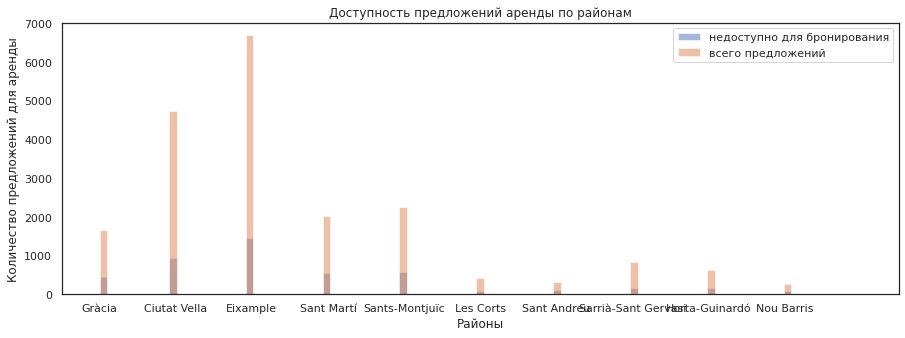

In [86]:
# Доступность предложений аренды по районам

# жилье недоступное для бронирования
filtered_availability = df[df['availability_365'] == 0]

X = filtered_availability['neighbourhood_group']
Y = df['neighbourhood_group']

bins = np.linspace(0, 10, 100)

plt.hist(X, bins, alpha=0.5, label='недоступно для бронирования')
plt.hist(Y, bins, alpha=0.5, label='всего предложений')
plt.legend(loc='upper right')
plt.xlabel('Районы')
plt.ylabel('Количество предложений для аренды')
plt.title('Доступность предложений аренды по районам')

Text(0.5, 1.0, 'Доступность предложений аренды по районам')

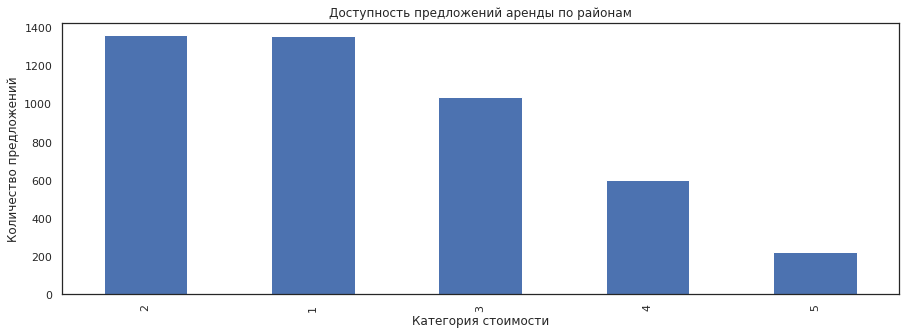

In [87]:
# категории стоимости недоступных для бронирования предложений аренды
filtered_availability['price_class'].value_counts().plot.bar()

plt.xlabel('Категория стоимости')
plt.ylabel('Количество предложений')
plt.title('Доступность предложений аренды по районам')

Text(0.5, 1.0, 'Доступность предложений аренды по районам')

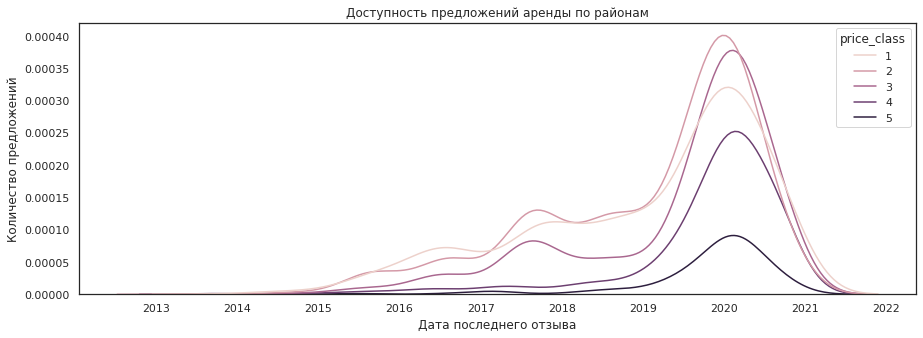

In [88]:
sns.kdeplot(data=filtered_availability, x='last_review_dt', hue='price_class')
plt.xlabel('Дата последнего отзыва')
plt.ylabel('Количество предложений')
plt.title('Доступность предложений аренды по районам')

### Нерелевантные признаки

In [89]:
# удаление неинформативных признаков
df = df.drop(
    ['id', 'host_id', 'name', 'minimum_nights', 'last_review', 'host_name'],
    axis=1)


### Порядковая регрессия

In [90]:
# Numeric columns
df_numeric = df.select_dtypes(include=[np.number])
df_numeric.columns.values

array(['latitude', 'longitude', 'price', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'price_class', 'room_class',
       'minimum_nights_class', 'last_review_rang',
       'neighbourhood_group_index', 'neighbourhood_index'], dtype=object)

In [91]:
from bevel.linear_ordinal_regression import OrderedLogit

In [92]:
# Подстановка параметров neighbourhood_index, neighbourhood_group_index, latitude+longitude проведена вручную

# Назначение зависимых(Y) и независимых(X) переменных
Y = df.price_class
X = df[[
    'neighbourhood_index',
    'room_class',
    'availability_365',
    'calculated_host_listings_count',
    'number_of_reviews',
    'reviews_per_month',
    'last_review_rang',
    'minimum_nights_class',
]]

In [93]:
X.dtypes

neighbourhood_index                 int64
room_class                          int64
availability_365                    int64
calculated_host_listings_count      int64
number_of_reviews                   int64
reviews_per_month                 float64
last_review_rang                    int64
minimum_nights_class                int64
dtype: object

In [94]:
# Построение регрессионной модели
model = OrderedLogit()
model.fit(X, Y)

In [95]:
model.print_summary()

n=19867
                                  beta  se(beta)      p  lower 0.95  upper 0.95     
attribute names                                                                     
neighbourhood_index            -0.0013    0.0007 0.0701     -0.0028      0.0001    .
room_class                      2.1090    0.0309 0.0000      2.0485      2.1695  ***
availability_365                0.0008    0.0001 0.0000      0.0006      0.0009  ***
calculated_host_listings_count  0.0018    0.0004 0.0000      0.0010      0.0027  ***
number_of_reviews               0.0031    0.0004 0.0000      0.0024      0.0038  ***
reviews_per_month              -0.2584    0.0221 0.0000     -0.3017     -0.2152  ***
last_review_rang               -0.4149    0.0284 0.0000     -0.4706     -0.3592  ***
minimum_nights_class           -0.0545    0.0012 0.0000     -0.0569     -0.0521  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Somers' D = 0.464
